In [1]:
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak
import sys
sys.path.insert(0,"../")

In [2]:
def getLZDF(f,nEvents=-1):
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [3]:
m4_100 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL4p0_pl100/HeavyNeutralLepton_Tree.root")
m4_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL4p0_pl1000/HeavyNeutralLepton_Tree.root")
m4_10  = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL4p0_pl10/HeavyNeutralLepton_Tree.root")

m1_100 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL1p0_pl100/HeavyNeutralLepton_Tree.root")
m1_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL1p0_pl1000/HeavyNeutralLepton_Tree.root")
m1_10  = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL1p0_pl10/HeavyNeutralLepton_Tree.root")

m2_100 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL2p0_pl100/HeavyNeutralLepton_Tree.root")
m2_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL2p0_pl1000/HeavyNeutralLepton_Tree.root")
m2_10  = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL2p0_pl10/HeavyNeutralLepton_Tree.root")

m7_100 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL7p0_pl100/HeavyNeutralLepton_Tree.root")
m7_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL7p0_pl1000/HeavyNeutralLepton_Tree.root")
m7_10000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL7p0_pl10000/HeavyNeutralLepton_Tree.root")

# m10_100 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL10p0_pl100/HeavyNeutralLepton_Tree.root")
# m10_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL10p0_pl1000/HeavyNeutralLepton_Tree.root")
# m10_10  = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL10p0_pl10/HeavyNeutralLepton_Tree.root")

In [3]:
m4_1000_mu= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_muonType_mHNL4p0_pl1000/HeavyNeutralLepton_Tree.root")

In [4]:

def selectABCD(p,events):
    llp                = p.buildLLP(events)
    good_lep,ele,muons = p.buildGoodLeptons(events)
    cluster       = p.buildCSCcluster(events,good_lep)
    clusterMasks   = p.selectCSCcluster(cluster,events)
    dt_cluster = p.buildDTcluster(events,good_lep)
    dt_clusterMasks = p.selectDTcluster(dt_cluster,events)    

    def buildMask(allMasks,cutnames):
        allcuts = allMasks[cutnames[0]]
        for i,cutname in enumerate(cutnames):
            allcuts = (allcuts) & allMasks[cutname]
        return allcuts
    
    if p.isElectronChannel:
        preselections = ['trigger_ele','MET',"METfilters",'good_lepton']
    else:
        preselections = ['trigger_mu','MET',"METfilters",'good_lepton']

    selectionMasks={}
    selectionMasks['Acceptance']   =ak.firsts(events.gLLP_csc)==1
    selectionMasks['Acceptance_dt']=ak.firsts(events.gLLP_dt)==1
    selectionMasks['METfilters']   =events.Flag2_all==True
    selectionMasks['trigger_ele']  =events.SingleEleTrigger==True
    selectionMasks['trigger_mu']   =events.SingleMuonTrigger==True
    selectionMasks['good_lepton']=ak.num(good_lep,axis=1)==1
    # selectionMasks['good_mu']      =ak.num(good_mu,axis=1)==1
    selectionMasks['MET']          =events.metEENoise>=30
    selectionMasks['n_cls']        =ak.num(cluster,axis=1)>=1
    selectionMasks['cls_ABCD']  = (   ((clusterMasks.jetVeto_mask) &(clusterMasks.muonVeto_mask))
        & (clusterMasks.ME11_12_veto)
        &((clusterMasks.MB1seg_veto) & (clusterMasks.RB1_veto))
        & (clusterMasks.IntimeCut)
        & (clusterMasks.timeSpreadCut)
        & (clusterMasks.ClusterID))
    selectionMasks['dt_cls_ABCD'] =( (( dt_clusterMasks.dt_jetVeto) &(dt_clusterMasks.dt_muonVeto))
                                            & (dt_clusterMasks.dt_MB1veto)
                                            & (dt_clusterMasks.dt_RPC)
                                            & (dt_clusterMasks.dt_MB1adj)
                                            & (dt_clusterMasks.dt_time))   
    regions = {
                "presel"         :preselections,
                "ABCD"         :preselections+["cls_ABCD"],
                "ABCD_dt"      :preselections+["dt_cls_ABCD"],        
    }

    CSC_cut = buildMask(selectionMasks,regions['ABCD'])
    DT_cut = buildMask(selectionMasks,regions['ABCD_dt'])    
    return CSC_cut,DT_cut,cluster,dt_cluster

def getWeight(gLLP_ctau, tau_old,tau_new):
    return np.exp(gLLP_ctau*(1/tau_old-1/tau_new))*(tau_old/tau_new)
def reweightXsec(ctau,mass):
    #ctau in mm
    #mass in GeV
    #xsec in pb
    cof={
        "1":9.51561675,
        "2":6.04926165,
        "4":2.55645182,
        "7":-0.29378948,
        "10":-2.11196473,
    }
    return np.exp(-1*np.log(ctau)+cof[mass]*np.ones_like(ctau))

In [19]:
m4_1000= getLZDF("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_electronType_mHNL4p0_pl1000/HeavyNeutralLepton_Tree.root")

In [5]:
from HNLprocessor.HNLproc_4 import MyProcessor
p = MyProcessor(isElectronChannel=True)
p_mu= MyProcessor(isElectronChannel=False)

# csc_cut,dt_cut,cls,cls_dt =selectABCD(p,m4_1000)
csc_cut,dt_cut,cls,cls_dt =selectABCD(p_mu,m4_1000_mu)

In [7]:
cls[ak.num(cls)>1]

<Array [[{time: 72.6, ... ] type='2913 * var * {"time": float32, "size": int32, ...'>

In [24]:
matchLLP = m4_1000_mu.cscRechitCluster3_match_gLLP

In [25]:
matchLLP==True

<Array [[], [], [], [], ... [], [], [], []] type='659710 * var * bool'>

In [177]:
sizeCut = 220
dphi_lepCut = 1.989675
dphi_METCut = 0.7


A = ((cls.dphi_cluster_lep<dphi_lepCut)&(cls.size>sizeCut) &(cls.dphi_cluster_MET<dphi_METCut))
B = ((cls.dphi_cluster_lep<dphi_lepCut)&(cls.size<sizeCut) &(cls.dphi_cluster_MET<dphi_METCut))
C = ((cls.dphi_cluster_lep>dphi_lepCut)&(cls.size<sizeCut) &(cls.dphi_cluster_MET<dphi_METCut))
SR = ((cls.dphi_cluster_lep>dphi_lepCut)&(cls.size>sizeCut) &(cls.dphi_cluster_MET<dphi_METCut))

SR_ev_cut = ak.any((csc_cut) & (matchLLP==True) & (SR),axis=1)
SR_cut = (csc_cut)  & (matchLLP==True) & (SR)
A_cut  = (csc_cut)  & (matchLLP==True) & (A)
B_cut  = (csc_cut)  & (matchLLP==True) & (B)
C_cut  = (csc_cut)  & (matchLLP==True) & (C)

In [166]:
ak.num(cls[SR_ev_cut],axis=1)>1

<Array [False, False, False, ... False, False] type='217 * bool'>

In [178]:
ak.sum(getWeight(ak.firsts(m4_1000_mu.gLLP_ctau),100,100)*ak.ones_like(cls.size)[A_cut])

235.0

In [180]:
ak.sum(getWeight(ak.firsts(m4_1000_mu.gLLP_ctau),100,100)*ak.ones_like(cls.size)[B_cut])

669.0

In [181]:
ak.sum(getWeight(ak.firsts(m4_1000_mu.gLLP_ctau),100,100)*ak.ones_like(cls.size)[C_cut])

601.0

In [183]:
ak.sum(getWeight(ak.firsts(m4_1000_mu.gLLP_ctau),100,100)*ak.ones_like(cls.size)[SR_cut])

217.0

In [192]:
reweightXsec(100,"4")

0.12890000039300367

In [191]:
reweightXsec(50,"4")

0.25780000078600745

In [179]:
# ctau new in mm 500
# lumi in pb
lumi = 137 *1000 
xsec = reweightXsec(1000,"4")
yields = 235

print("Yield = ",yields)
print("xsec   = ",xsec)
print("lumi x xsec", xsec*lumi)
print("Xsec weight", xsec*lumi/len(m4_1000_mu))

print("Yield at 137fb = ",yields * xsec *lumi/len(m4_1000_mu))

Yield =  235
xsec   =  0.012890000039300369
lumi x xsec 1765.9300053841505
Xsec weight 0.0026768277051797767
Yield at 137fb =  0.6290545107172475


In [175]:
1.41/0.58

2.4310344827586206

<AxesSubplot:xlabel='nhit', ylabel='Count'>

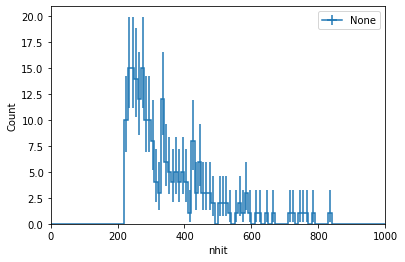

In [156]:
h= hist.Hist("Count",
             hist.Bin("size","nhit",100,0,1000))
h.fill(size=ak.flatten(cls[SR_cut].size))
hist.plot1d(h)

In [136]:
cls_short=cls[ak.any(csc_cut,axis=1)]

In [141]:
cls_short[ak.num(cls[ak.any(csc_cut,axis=1)])>1].size

<Array [[280, 87], [90, 75, ... 55], [73, 54]] type='18 * var * int32'>

In [56]:



c
cls_ABCD = ak.flatten(cls[csc_cut])


In [64]:
cls = cls[mask]

In [65]:
cls

<Array [{time: -0.26, ... dr_cluster_lep: 3.1}] type='11 * {"time": float32, "si...'>

In [54]:
cls.fields

['time',
 'size',
 'timeSpread',
 'eta',
 'phi',
 'x',
 'y',
 'z',
 'llp_x',
 'llp_y',
 'llp_z',
 'NChamber',
 'MaxChamber',
 'MaxStation',
 'NStation10',
 'AvgStation10',
 'ME11_12',
 'llp_match',
 'RE12',
 'MB1seg',
 'RB1',
 'dphi_cluster_MET',
 'dphi_cluster_lep',
 'dr_cluster_lep']

In [26]:
ak.flatten(cluster[cut])

<Array [] type='0 * {"time": float32, "size": int32, "timeSpread": float32, "eta...'>

In [8]:
lep=ak.zip({
    'pt':events.lepPt ,
    'eta':events.lepEta,
    'phi':events.lepPhi,
    'energy':events.lepE,
    'pdgid':events.lepPdgId,
    'passId':events.lepPassId,
},with_name='PtEtaPhiELorentzVector',
behavior=vector.behavior
)

In [7]:
# events =events_1 
cluster= ak.zip(
    {
        "time":events.cscRechitCluster3Time,
        'size':events.cscRechitCluster3Size,
        "timeSpread":events.cscRechitCluster3TimeSpread,
        "eta":events.cscRechitCluster3Eta,
        "phi":events.cscRechitCluster3Phi,        
        "x":events.cscRechitCluster3X,
        "y":events.cscRechitCluster3Y,
        "z":events.cscRechitCluster3Z,   
        'llp_x':events.cscRechitCluster3_match_gLLP_decay_x,
        'llp_y':events.cscRechitCluster3_match_gLLP_decay_y,
        'llp_z':events.cscRechitCluster3_match_gLLP_decay_z,        
        "NChamber":events.cscRechitCluster3NChamber,
        "MaxChamber":events.cscRechitCluster3MaxChamber,
        "MaxStation":events.cscRechitCluster3MaxStation,
        'ME11ratio':events.cscRechitCluster3Me11Ratio,
        'ME12ratio':events.cscRechitCluster3Me12Ratio,        
        'match_MB1Seg_0p4':events.cscRechitCluster3_match_MB1Seg_0p4,
        'match_RE12_0p4':events.cscRechitCluster3_match_RE12_0p4,        
        'match_RB1_0p4':events.cscRechitCluster3_match_RB1_0p4,                
        "NStation10":events.cscRechitCluster3NStation10,
        "AvgStation10":events.cscRechitCluster3AvgStation10,
        "llp_match":events.cscRechitCluster3_match_gLLP,
        "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,
    }
)


In [19]:
llp[845].to_list()

[{'pt': 15.53358268737793,
  'EMfrac': 0.3645990192890167,
  'e': 703.39697265625,
  'z': 265.89727783203125,
  'y': -4.984921932220459,
  'x': 2.8567469120025635,
  'r': 5.745472431182861},
 {'pt': -666.0,
  'EMfrac': -0.38507184386253357,
  'e': -666.0,
  'z': -666.0,
  'y': -666.0,
  'x': -666.0,
  'r': 941.8662109375}]

In [14]:
cluster[845].to_list()

[{'time': -21.936141967773438,
  'size': 57,
  'timeSpread': 24.42901611328125,
  'eta': 2.1560451984405518,
  'phi': 2.2853572368621826,
  'x': -134.80467224121094,
  'y': 155.39617919921875,
  'z': 876.4788208007812,
  'llp_x': 999.0,
  'llp_y': 999.0,
  'llp_z': 999.0,
  'NChamber': 2,
  'MaxChamber': 21,
  'MaxStation': 2,
  'ME11ratio': 0.07017543911933899,
  'ME12ratio': 0.0,
  'match_MB1Seg_0p4': 0,
  'match_RE12_0p4': 0,
  'match_RB1_0p4': 0,
  'NStation10': 2,
  'AvgStation10': 2.5,
  'llp_match': False,
  'dphi_cluster_MET': -2.501770257949829},
 {'time': 19.592082977294922,
  'size': 53,
  'timeSpread': 13.656285285949707,
  'eta': -2.237352132797241,
  'phi': 0.2382594794034958,
  'x': 179.5574951171875,
  'y': 43.609619140625,
  'z': -855.6812133789062,
  'llp_x': 999.0,
  'llp_y': 999.0,
  'llp_z': 999.0,
  'NChamber': 4,
  'MaxChamber': -31,
  'MaxStation': -3,
  'ME11ratio': 0.22641509771347046,
  'ME12ratio': 0.0,
  'match_MB1Seg_0p4': 0,
  'match_RE12_0p4': 0,
  'matc

In [24]:
muons = lep[abs(lep.pdgid)==13]
# good_ele = ele[(ele.pt>35) & (abs(ele.eta)<2.4) & (ele.passId)]
good_mu  = muons[(muons.pt>25)&(abs(muons.eta)<2.4) & (muons.passId)]

In [26]:
presel = (events.SingleMuonTrigger==True) &\
        (events.metEENoise>=30) &\
        (events.Flag2_all) &\
        (ak.num(good_mu,axis=1)==1)


In [1]:
## Here a = all clusters
## b = clusters that passes selections

a = ak.Array([[100,200],[50],[10],[100,300,400]])
clusterSelections = a>150
b =a[clusterSelections]
print(b)

NameError: name 'ak' is not defined

In [38]:
print(a>150)                 ## Note multiple objects per event
print(ak.num(a>150,axis=1))  ## This counts number of _objects_ in a per event
print(ak.num(b,axis=1))      ## This counts number of clusters that passes the selection 

[[False, True], [False], [False], [False, True, True]]
[2, 1, 1, 3]
[1, 0, 0, 2]


In [39]:
print(ak.num(a>150,axis=1)>=1)    ## this is wrong
print(ak.any(a>150,axis=1)>=1)    ## this is correct, if we use ak.any
print(ak.num(b,axis=1)>=1)        ## this is correct

eventMask = ak.num(b,axis=1)>=1   ## In the processor, we chose this method

[True, True, True, True]
[True, False, False, True]
[True, False, False, True]


In [40]:
print(a[eventMask])    ## This is what we're filling the histogram with, hence extra clusters are there

[[100, 200], [100, 300, 400]]


In [59]:
### Solution 1: apply the mask
b[eventMask]           ## This will filter out the wrong clusters, but keep the right events

<Array [[200], [300, 400]] type='2 * var * int64'>

In [60]:
### Solution 2: apply the &
a[eventMask &clusterSelections] ## This should only keep the right events with right clusters

<Array [[200], [], [], [300, 400]] type='4 * var * int64'>

In [57]:
print(a)
eventMask = ak.any(a>150,axis=1)>=1
clusterMask = a>150
print(eventMask)  ## event mask
print(clusterMask)                    ## cluster mask
print(a[eventMask & clusterMask])    ## I want this array
b = a[clusterMask]
print(b[eventMask]) ## Can do this

[[100, 200], [50], [10], [100, 300, 400]]
[True, False, False, True]
[[False, True], [False], [False], [False, True, True]]
[[200], [], [], [300, 400]]
[[200], [300, 400]]


In [47]:
from coffea.analysis_tools import Weighats, PackedSelection

## This is the final array that we're filling the histograms
eventSelection = PackedSelection(np.uint64)
clusterSelection = PackedSelection(np.uint64)

eventSelection.add("event",eventMask)
clusterSelection.add("cls",clusterSelections)
allcuts = ["event","cls"]
cut = selections.require(*allcuts)
print(cut)
ak.flatten(a[cut]) 

ValueError: Expected an array of type N * primitive or N * ?primitive, received: 4 * var * bool

In [71]:
sel = ak.num(cluster.size>200,axis=1)>0
sel2 = ak.any(cluster.size>200,axis=1)

<AxesSubplot:xlabel='nhit', ylabel='Count'>

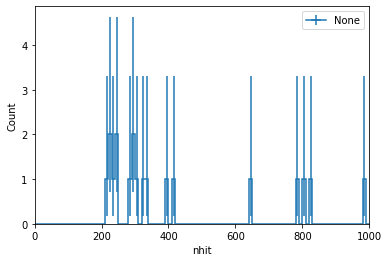

In [76]:
h= hist.Hist("Count",
             hist.Bin("size","nhit",100,0,1000))
h.fill(size=ak.flatten(arr))
hist.plot1d(h)

In [48]:
acc10 = ak.sum(ak.firsts(events_1.gLLP_csc))/len(events_1)
acc7 = ak.sum(ak.firsts(events_2.gLLP_csc))/len(events_2)